In [1]:
!pip install transformers datasets matplotlib pandas seaborn evaluate seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.2 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=84485af69d6b7d10bc7c8c3a93480910ea60c89647105515254dcf19ea549798
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datasets import load_dataset
from collections import Counter
from transformers import (
    BertTokenizerFast,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
    AlbertForSequenceClassification,AutoTokenizer,
)
from google.colab import drive
import os
import json
import evaluate

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset = load_dataset("conll2003")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [5]:
# tokenization function
def tokenize_and_align_labels(examples, tokenizer, label_all_tokens=True):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True,
    )
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [6]:
seqeval = evaluate.load("seqeval")
label_names = dataset["train"].features["ner_tags"].feature.names

def metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=2)
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [7]:
tinybert_tokenizer = BertTokenizerFast.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
tokenized_datasets_tinybert = dataset.map(lambda x: tokenize_and_align_labels(x, tinybert_tokenizer), batched=True)

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [8]:
data_collator_tinybert = DataCollatorForTokenClassification(tinybert_tokenizer)


In [10]:
tinybert_model = AutoModelForTokenClassification.from_pretrained(
    "huawei-noah/TinyBERT_General_4L_312D", num_labels=len(label_names)
)

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
tinybert_args = TrainingArguments(
    "tinybert-ner",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir='./logs',
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
tinybert_trainer = Trainer(
    tinybert_model,
    tinybert_args,
    train_dataset=tokenized_datasets_tinybert["train"],
    eval_dataset=tokenized_datasets_tinybert["validation"],
    data_collator=data_collator_tinybert,
    tokenizer=tinybert_tokenizer,
    compute_metrics=metrics,
)

<ipython-input-12-306eeb234b29>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tinybert_trainer = Trainer(


In [13]:
# Train TinyBERT
print("Training TinyBERT...")
tinybert_trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Training TinyBERT...


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.512800,0.221185,0.721301,0.768990,0.744382,0.946129
2,0.203300,0.166938,0.808567,0.823582,0.816005,0.958886
3,0.161700,0.154763,0.813706,0.839468,0.826386,0.960935


TrainOutput(global_step=2634, training_loss=0.25866370899892704, metrics={'train_runtime': 75.7695, 'train_samples_per_second': 555.936, 'train_steps_per_second': 34.763, 'total_flos': 54833231758662.0, 'train_loss': 0.25866370899892704, 'epoch': 3.0})

In [14]:
tinybert_drive_path = "/content/drive/My Drive/NER_Models_upload/tinybert_model"

In [15]:
os.makedirs(tinybert_drive_path, exist_ok=True)
tinybert_model.save_pretrained(tinybert_drive_path)
tinybert_tokenizer.save_pretrained(tinybert_drive_path)



('/content/drive/My Drive/NER_Models_upload/tinybert_model/tokenizer_config.json',
 '/content/drive/My Drive/NER_Models_upload/tinybert_model/special_tokens_map.json',
 '/content/drive/My Drive/NER_Models_upload/tinybert_model/vocab.txt',
 '/content/drive/My Drive/NER_Models_upload/tinybert_model/added_tokens.json',
 '/content/drive/My Drive/NER_Models_upload/tinybert_model/tokenizer.json')

In [16]:
print("Model successfully saved to Google Drive!")

Model successfully saved to Google Drive!


In [17]:
import matplotlib.pyplot as plt

# Function to extract metrics from logs

def extract_metrics(trainer_logs):
    """
    Extract metrics (loss, eval_loss, precision, recall, accuracy) from trainer logs.

    Args:
        trainer_logs (list): Logs from the trainer state.

    Returns:
        dict: Dictionary containing metrics and their corresponding steps.
    """
    metrics = {
        "train_loss": [log["loss"] for log in trainer_logs if "loss" in log],
        "train_steps": [log["step"] for log in trainer_logs if "loss" in log],
        "eval_loss": [log["eval_loss"] for log in trainer_logs if "eval_loss" in log],
        "eval_steps": [log["step"] for log in trainer_logs if "eval_loss" in log],
        "precision": [log["eval_precision"] for log in trainer_logs if "eval_precision" in log],
        "precision_steps": [log["step"] for log in trainer_logs if "eval_precision" in log],
        "recall": [log["eval_recall"] for log in trainer_logs if "eval_recall" in log],
        "recall_steps": [log["step"] for log in trainer_logs if "eval_recall" in log],
        "accuracy": [log["eval_accuracy"] for log in trainer_logs if "eval_accuracy" in log],
        "accuracy_steps": [log["step"] for log in trainer_logs if "eval_accuracy" in log],
    }
    return metrics


In [18]:
# Function to plot
def plot_comparison(metrics, model_name):

    # Training Loss
    plt.figure(figsize=(8, 5))
    plt.plot(metrics["train_steps"], metrics["train_loss"], label=f"{model_name} Training Loss", color="blue")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss Comparison")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(metrics["eval_steps"], metrics["eval_loss"], label=f"{model_name} Validation Loss", color="red")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Validation Loss Comparison")
    plt.legend()
    plt.show()


     # Precision Comparison
    plt.figure(figsize=(8, 5))
    plt.plot(metrics["precision_steps"], metrics["precision"], label=f"{model_name} Precision", color="purple")
    plt.xlabel("Steps")
    plt.ylabel("Precision")
    plt.title("Precision Comparison")
    plt.legend()
    plt.show()



    # Recall Comparison
    plt.figure(figsize=(8, 5))
    plt.plot(metrics["recall_steps"], metrics["recall"], label=f"{model_name} Recall", color="cyan")
    plt.xlabel("Steps")
    plt.ylabel("Recall")
    plt.title("Recall Comparison")
    plt.legend()
    plt.show()



    # Accuracy Comparison
    plt.figure(figsize=(8, 5))
    plt.plot(metrics["accuracy_steps"], metrics["accuracy"], label=f"{model_name} Accuracy", color="orange")
    plt.xlabel("Steps")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Comparison")
    plt.legend()
    plt.show()

In [19]:
tinybert_logs = tinybert_trainer.state.log_history
tinybert_metrics = extract_metrics(tinybert_logs)

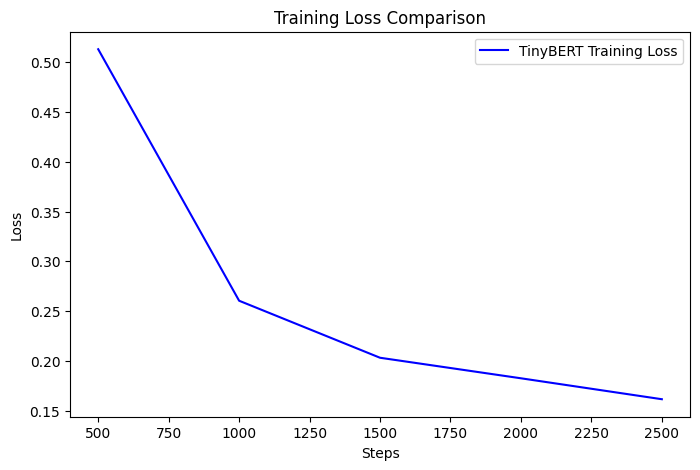

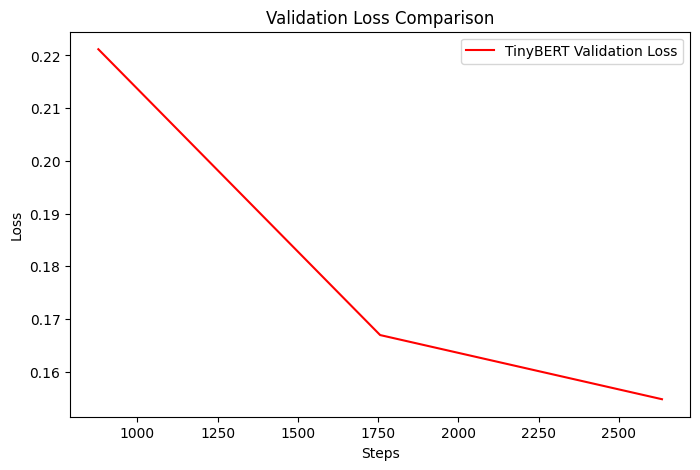

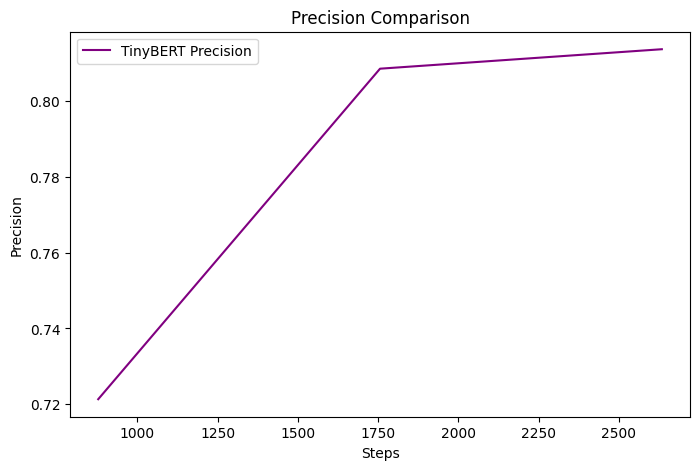

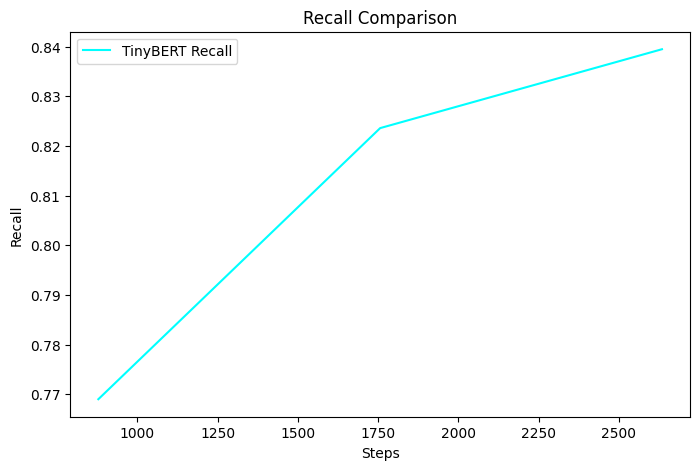

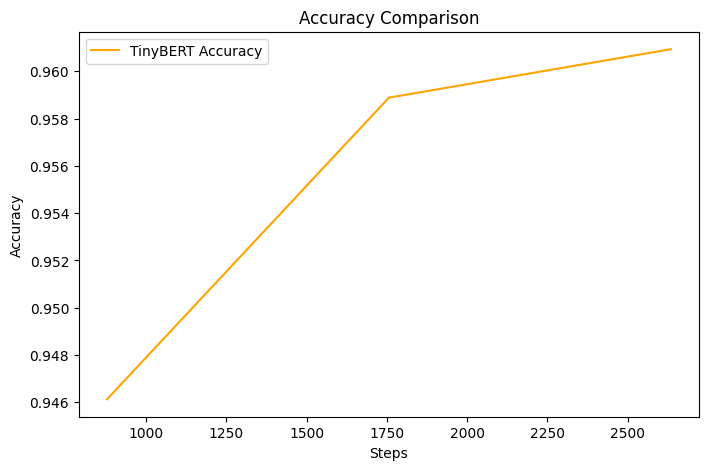

In [20]:
# Plot Comparison Graphs
plot_comparison(tinybert_metrics,  "TinyBERT")

In [21]:
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer

model_path = '/content/drive/My Drive/NER_Models_upload/tinybert_model'

model = AutoModelForTokenClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)

Device set to use cuda:0


In [22]:
text = "Apple is looking at buying U.K. startup for $1 billion"

result = ner_pipeline(text)

# Map labels to original names (if needed)
label_list = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
for entity in result:
    entity['entity'] = label_list[int(entity['entity'].split('_')[1])]

print(result)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'entity': 'B-ORG', 'score': 0.8463931, 'index': 1, 'word': 'apple', 'start': 0, 'end': 5}, {'entity': 'O', 'score': 0.9868329, 'index': 2, 'word': 'is', 'start': 6, 'end': 8}, {'entity': 'O', 'score': 0.9868693, 'index': 3, 'word': 'looking', 'start': 9, 'end': 16}, {'entity': 'O', 'score': 0.9870237, 'index': 4, 'word': 'at', 'start': 17, 'end': 19}, {'entity': 'O', 'score': 0.98492706, 'index': 5, 'word': 'buying', 'start': 20, 'end': 26}, {'entity': 'B-ORG', 'score': 0.47988045, 'index': 6, 'word': 'u', 'start': 27, 'end': 28}, {'entity': 'B-ORG', 'score': 0.42543676, 'index': 7, 'word': '.', 'start': 28, 'end': 29}, {'entity': 'B-ORG', 'score': 0.52627337, 'index': 8, 'word': 'k', 'start': 29, 'end': 30}, {'entity': 'B-ORG', 'score': 0.56629837, 'index': 9, 'word': '.', 'start': 30, 'end': 31}, {'entity': 'O', 'score': 0.6498156, 'index': 10, 'word': 'startup', 'start': 32, 'end': 39}, {'entity': 'O', 'score': 0.98658895, 'index': 11, 'word': 'for', 'start': 40, 'end': 43}, {'ent